### Importamos las librerías necesarias.

In [1]:
# Utilidades de torch
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

# Herramientas varias
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from collections import OrderedDict
import joblib

# Clases propias
from models.Unet import Unet
from CustomClothingDataset import CustomClothingDataset
from trainers.ModelTrainer import ModelTrainer
from trainers.TransferLearningTrainer import TransferLearningTrainer
from EarlyStopper import EarlyStopper
from models.Resnet101 import Resnet101
from models.MobileNetV3 import MobileNetV3
from models.ResNet50 import ResNet50
from LabelManagement.LabelDecoder import LabelDecoder

Definimos unas variables iniciales para trabajar, pudiendose cambiar más adelante.

In [2]:
# Inicialización

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Definición de constantes 

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 8
EPOCHS = 10
DATASET_DIR = './data/'
MODELS_DIR = 'models/'
#print(torch.cuda.get_device_name())

Using cuda device


Comprobamos los tamaños más grandes y más pequeños de cada set de imágenes:

In [3]:


sizes = []
for image in os.listdir('./data/images/colored_labels'):
    sizes.append(read_image("./data/images/colored_labels/" + image).shape)
print("Range for inputs with segmentation: ")
print(max(sizes))
print(min(sizes))

sizes = []
for image in os.listdir('./data/images/text_labels'):
    sizes.append(read_image("./data/images/text_labels/" + image).shape)
print("Range for inputs with txt: ")
print(max(sizes))
print(min(sizes))


Range for inputs with segmentation: 
torch.Size([3, 873, 550])
torch.Size([3, 801, 550])
Range for inputs with txt: 
torch.Size([3, 877, 550])
torch.Size([3, 786, 550])


El tamaño mayor es de 877x550 y el menor es de 786x550.

### Codificación

A continuación, creamos un codificador para pasar de color de segmentación, a una clase One Hot:

In [4]:
classes = pd.read_csv(DATASET_DIR + "/class_dict.csv")

# Si tuvieramos que volver a crear el codificar las líneas serían las siguientes:
#encoder = OneHotEncoder(sparse=False) #joblib.dump(encoder,"one_hot_encoder.joblib")
#codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1))

# Ya lo tenemos guardado así que lo cargamos:
encoder = joblib.load('one_hot_encoder.joblib')
codes = encoder.transform(classes["class_name"].values.reshape(-1,1))
codigo_none = codes[0]
codigo_accesorios = codes[1]

uncoded = encoder.inverse_transform([codigo_none, codigo_accesorios])
print("one hot de None y de accesorios devuelve segun encoder: ", uncoded)

print("Sus colores segun el dataframe: \n", classes[classes["class_name"].isin(uncoded.flatten())][["r","g","b"]])

one hot de None y de accesorios devuelve segun encoder:  [['none']
 ['accessories']]
Sus colores segun el dataframe: 
     r   g   b
0  69   6  90
1  70  12  95


Creamos un dataframe a partir de metadatos del dataset, contiene la clase, su color, su representación en One Hot, en array de numpy y en tensor.

In [5]:

codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1)).astype(np.uint8)
encoded_df = pd.concat([classes, pd.Series(list(codes[:]))], axis=1).rename(columns={0: "One-hot"}, inplace=False)
encoded_df["array_value"] = encoded_df[["r","g","b"]].apply(lambda x: np.array([x.r, x.g, x.b], dtype=np.uint8), axis=1)
encoded_df["tensor_value"] = encoded_df[["r","g","b"]].apply(lambda x: torch.tensor([x.r, x.g, x.b], dtype=torch.uint8), axis=1)
encoded_df

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,class_name,r,g,b,One-hot,array_value,tensor_value
0,none,69,6,90,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[69, 6, 90]","[tensor(69, dtype=torch.uint8), tensor(6, dtyp..."
1,accessories,70,12,95,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 12, 95]","[tensor(70, dtype=torch.uint8), tensor(12, dty..."
2,bag,71,18,101,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 18, 101]","[tensor(71, dtype=torch.uint8), tensor(18, dty..."
3,belt,72,25,107,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 25, 107]","[tensor(72, dtype=torch.uint8), tensor(25, dty..."
4,blazer,72,30,112,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 30, 112]","[tensor(72, dtype=torch.uint8), tensor(30, dty..."
5,blouse,72,35,116,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 35, 116]","[tensor(72, dtype=torch.uint8), tensor(35, dty..."
6,bodysuit,71,40,120,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 40, 120]","[tensor(71, dtype=torch.uint8), tensor(40, dty..."
7,boots,70,47,124,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 47, 124]","[tensor(70, dtype=torch.uint8), tensor(47, dty..."
8,bra,69,52,127,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[69, 52, 127]","[tensor(69, dtype=torch.uint8), tensor(52, dty..."
9,bracelet,68,57,130,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[68, 57, 130]","[tensor(68, dtype=torch.uint8), tensor(57, dty..."


Creamos un diccionario a partir de los bytes de cada color, con su correspondiente OneHot:

In [6]:
encoded_df["byte_value"] = encoded_df["array_value"].apply(lambda x: x.tobytes())

array_to_onehot = encoded_df[["byte_value", "One-hot"]].set_index('byte_value').to_dict()["One-hot"]
array_to_onehot

{b'E\x06Z': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'F\x0c_': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'G\x12e': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'H\x19k': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'H\x1ep': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

Para preprocesar todas las imágenes de segmentación (labels), y evitar que tengamos que codificarlas en one hot en cada ejecución, las preprocesamos antes con el diccionario de arriba y las guardamos en disco.

Toda la lógica de codificación se ecapsuló en LabelEncoder:

In [7]:
#LabelEncoder("./data/labels/pixel_level_labels_colored", "./data/labels/processed_pixel_labels/",
#                  "./data/class_dict.csv", "./one_hot_encoder.joblib").preprocess()
# Ejecutar únicamente si no se ejecutó antes
# Antes de ejecutar, crear carpeta en /data/labels/processed_pixel_labels

Para cargar el dataset con las carga y número de transformaciones adecuadas, creamos la clase CustomClothingDataset.

In [8]:
dataset = CustomClothingDataset(root_dir=DATASET_DIR) 
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE) 

Con esa clase, probamos a decodificar una de las imágenes guardadas en disco para ver que no se ha perdido información:

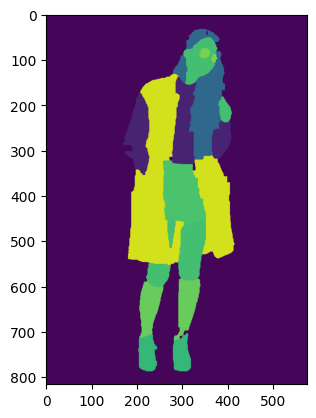

In [9]:
onehot_to_array = {v.tobytes(): k for k, v in array_to_onehot.items()}
def decode_image(image):
    return np.apply_along_axis(lambda pixel: np.frombuffer(onehot_to_array[pixel.tobytes()], dtype=np.uint8), 0, np.array(image, np.uint8)).transpose(1,2,0)

label = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[1]
plt.imshow(decode_image(label))

Ejemplo del dataset:

Cantidad de imágenes:  1004


C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([59, 496, 304])


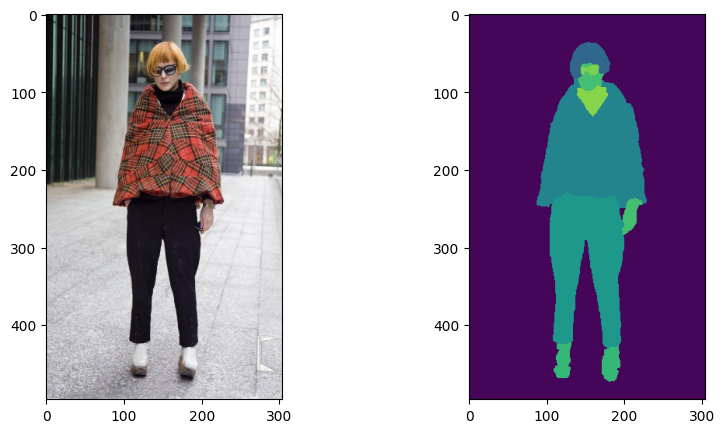

In [10]:
dataset = CustomClothingDataset(root_dir=DATASET_DIR,
                                transform_input=transforms.Compose([
                     transforms.Resize((496, 304)), 
                 ]),
                                transform_labels=transforms.Compose([transforms.Resize((496, 304), interpolation=InterpolationMode.NEAREST_EXACT)                                                                  
    ])
                                )
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Cantidad de imágenes: ", len(data_loader.dataset))

for image, label in data_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(image[0].int(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    print(label[0].shape)
    plt.imshow(decode_image(label[0]))
    plt.show()
    break

## Implementación de modelo propio


### Creación de DataLoaders

Comenzamos definiendo los DataLoaders de 70% en Train, 15% validación y 15% test. El BATCH_SIZE lo variamos para que a pesar del gran tamaño de las imágenes, sigan cabiendo en la GPU. 

In [13]:
BATCH_SIZE = 16
full_dataset = CustomClothingDataset(root_dir=DATASET_DIR,                 
                                     transform_input=transforms.Compose([
                     transforms.Resize((496, 304), interpolation=InterpolationMode.BILINEAR, antialias=True), # Reducimos las imágenes
                     transforms.Lambda(lambda x: x / 255), # escalamos de 0 a 1
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                 ]),
                                     transform_labels=transforms.Compose([
                    transforms.Resize((496, 304), interpolation=InterpolationMode.NEAREST_EXACT), # Para las labels reducimos con
                                         # "Nearest_Exact para no perder la codificación OneHot.
                 ]),)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
 
loss_fn = torch.nn.CrossEntropyLoss() # Mide la discrepancia entre la distribución de probabilidad predicha y la distribución real de clases, ideal para multiclase.


### Implementación U-NET

Probamos a entrenar la U-net, dibujamos los resultados y los testeamos.

Epoch: 1, Train acc: 72.47802766259632, loss: 1.40849115496332 //// Val acc: 76.3446519524618 loss: 1.4606694340705872
Epoch: 2, Train acc: 78.06646359510057, loss: 0.9242377077991312 //// Val acc: 77.35677083333333 loss: 0.9241387605667114
Epoch: 3, Train acc: 79.1330966369432, loss: 0.8558025820688768 //// Val acc: 78.83210420203734 loss: 0.8550073087215424
Epoch: 4, Train acc: 79.40981934044856, loss: 0.8217737471515482 //// Val acc: 79.33857261601584 loss: 0.8512271702289581
Epoch: 5, Train acc: 79.93192900378014, loss: 0.7834762239998038 //// Val acc: 78.76399794850028 loss: 0.8514919936656952
Epoch: 6, Train acc: 80.05717089240538, loss: 0.7634844468398527 //// Val acc: 79.54525679117147 loss: 0.7885053098201752
Epoch: 7, Train acc: 80.51921085432599, loss: 0.7396328002214432 //// Val acc: 80.61458333333334 loss: 0.7951396942138672
Epoch: 8, Train acc: 80.91781598718673, loss: 0.7169375717639923 //// Val acc: 80.8973940647991 loss: 0.7075792670249939
Epoch: 9, Train acc: 81.58100

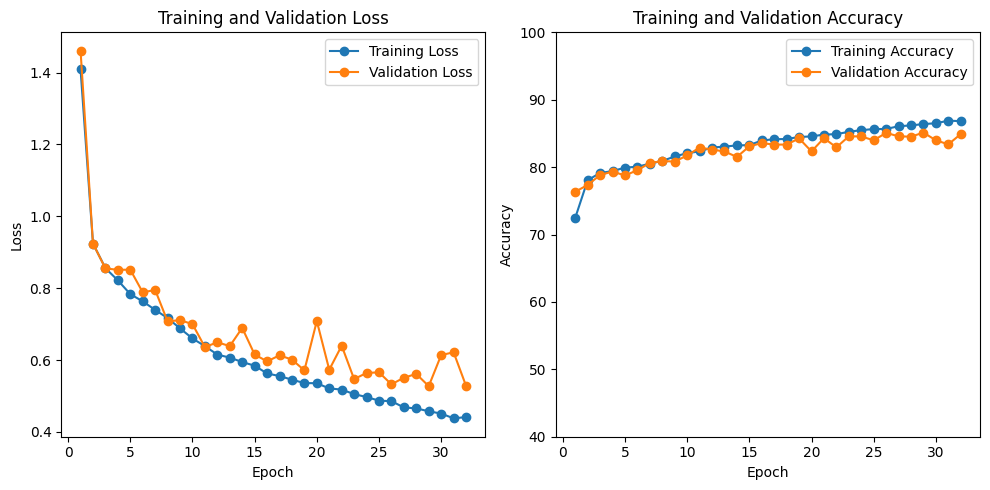

Test Accuracy: 84.5%, Avg loss: 0.541486 


In [15]:
model = Unet().to(device) # defino el modelo y lo mando a GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # defino optimizador
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True) # defino el scheduler
unetTrainer = ModelTrainer(model, optimizer, loss_fn, 32, EarlyStopper(patience=7), device, scheduler) # llamo a la clase encargada del entrenamiento
unetTrainer.train_and_val(train_loader, val_loader)
unetTrainer.draw_results()
unetTrainer.test(test_loader)


A partir de la época 32 comenzaba a haber un poco de overfitting, es posible que con un learning rate más bajo pudiese mejorar. Tenemos un 84.5% en test.

Si necesitasemos guardar el modelo y sus resultados utilizamos la casilla siguiente:

In [18]:
#torch.save(unetTrainer.model, r".\results\unet.pth")
#unetTrainer.result.to_csv(r".\results\unet.csv",index=False)

## Implementaciones por transfer learning
### Implementación de Resnet50

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train acc: 1.786962138856239, loss: 4.005847492001274 //// Val acc: 6.608389042161857 loss: 3.95332612991333
Epoch: 2, Train acc: 6.608862238438319, loss: 3.9043095870451494 //// Val acc: 21.947987408036223 loss: 3.842438220977783
Epoch: 3, Train acc: 17.511271193691076, loss: 3.799297582019459 //// Val acc: 37.66446042020374 loss: 3.7434356451034545
Epoch: 4, Train acc: 31.44434793084518, loss: 3.692364611408927 //// Val acc: 50.03623726655348 loss: 3.630712890625
Epoch: 5, Train acc: 43.98905915943533, loss: 3.583961405537345 //// Val acc: 57.47755730050934 loss: 3.51680645942688
Epoch: 6, Train acc: 52.71639301244565, loss: 3.4787895625287835 //// Val acc: 61.05144223967175 loss: 3.42935996055603
Epoch: 7, Train acc: 58.5339145915865, loss: 3.37891286611557 //// Val acc: 63.93654057017543 loss: 3.3223068952560424
Epoch: 8, Train acc: 62.28300217151818, loss: 3.2873077338392083 //// Val acc: 65.53281515280136 loss: 3.241568088531494
Epoch: 9, Train acc: 64.67637316102672, l

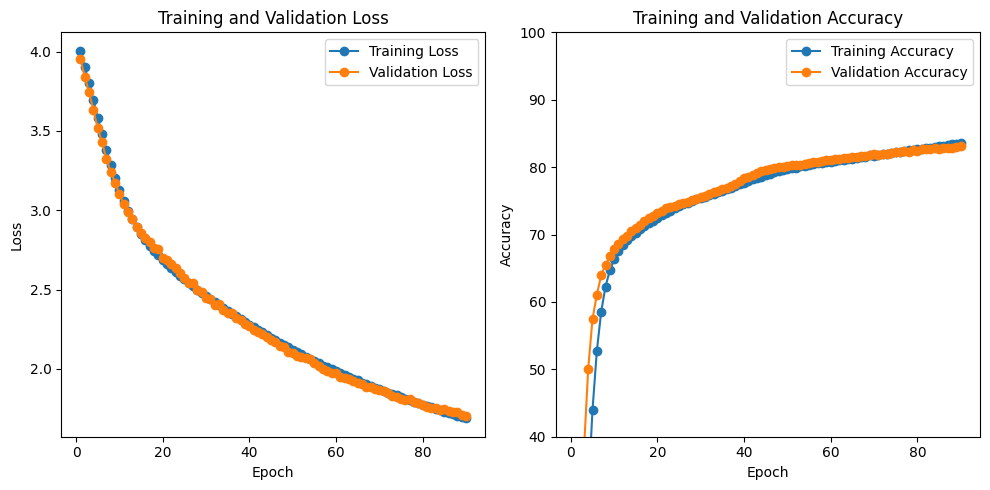

Test Accuracy: 83.8%, Avg loss: 1.676411 


In [16]:
resnet50_model = ResNet50(num_classes=59) #incluyendo el NONE
resnet50_model = resnet50_model.to(device)
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.000001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
resnet50_trainer = TransferLearningTrainer(resnet50_model, optimizer, loss_fn, 90, EarlyStopper(patience=3, min_delta=0.01, max_loss_diff=0.15), device, scheduler)
resnet50_trainer.train_and_val(train_loader, val_loader)
resnet50_trainer.draw_results()
resnet50_trainer.test(test_loader)

Nos quedamos con un 83.8% en test.

Es posible que con un buen uso del EarlyStopper y un mayor número de épocas pudiese mejorar más.

### Implementación de MobileNetV3

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train acc: 16.750620082870185, loss: 4.00531096350063 //// Val acc: 52.575794956140356 loss: 3.484263849258423
Epoch: 2, Train acc: 55.99196972087994, loss: 3.364262282848358 //// Val acc: 62.83290446378042 loss: 3.071367025375366
Epoch: 3, Train acc: 66.91364644098357, loss: 2.996344409205697 //// Val acc: 67.75772407328806 loss: 2.8675694465637207
Epoch: 4, Train acc: 70.46581359074727, loss: 2.8076877919110386 //// Val acc: 69.63787935059423 loss: 2.745561146736145
Epoch: 5, Train acc: 71.76815294586409, loss: 2.667502511631359 //// Val acc: 71.14173033389926 loss: 2.6175883054733275
Epoch: 6, Train acc: 72.5018121807569, loss: 2.5445354797623376 //// Val acc: 72.13346685766837 loss: 2.506333422660828
Epoch: 7, Train acc: 73.04463126665748, loss: 2.4305905537171797 //// Val acc: 72.58223684210526 loss: 2.4193275451660154
Epoch: 8, Train acc: 73.44760388551505, loss: 2.3297712965445085 //// Val acc: 73.18866281126202 loss: 2.315626859664917
Epoch: 9, Train acc: 73.789209688

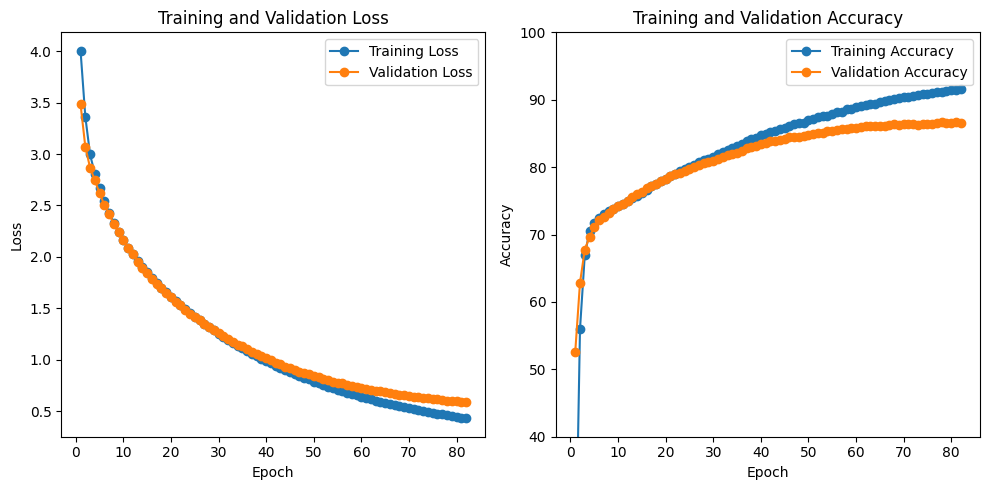

Test Accuracy: 86.3%, Avg loss: 0.616648 


In [23]:
mobilenetv3_model = MobileNetV3(num_classes=59)
mobilenetv3_model = mobilenetv3_model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenetv3_model.parameters(), lr=0.00001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
mobilenetv3_trainer = TransferLearningTrainer(mobilenetv3_model, optimizer, loss_fn, 85, EarlyStopper(patience=3, min_delta=0.01, max_loss_diff=0.15), device, scheduler)
mobilenetv3_trainer.train_and_val(train_loader, val_loader)
mobilenetv3_trainer.draw_results()
mobilenetv3_trainer.test(test_loader)

La MobileNetS3 consigue un 86.3% en testing, lo cuál es ideal. Si se hubiese entrenado más épocas habría llevado a overfitting.

### Implementación de RESNET_101

La Resnet101 es tan pesada que si no reducimos el BATCH_SIZE los tensores no cabrían en la GPU por lo que es necesario reducirlas.

In [16]:
BATCH_SIZE=12
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train acc: 31.24053853076826, loss: 3.622124336533627 //// Val acc: 60.56906568336162 loss: 3.1048515209784875
Epoch: 2, Train acc: 64.2574440553669, loss: 2.8471940695229225 //// Val acc: 70.21459394453876 loss: 2.5866464651547947
Epoch: 3, Train acc: 72.02958141817703, loss: 2.4137350866350076 //// Val acc: 74.68001025749858 loss: 2.261258363723755
Epoch: 4, Train acc: 75.51528682451062, loss: 2.1651118933144264 //// Val acc: 76.8856731041313 loss: 2.1067290122692404
Epoch: 5, Train acc: 77.74026633521012, loss: 2.0055746931140708 //// Val acc: 79.09519135540464 loss: 1.9199679081256573
Epoch: 6, Train acc: 79.2958017869149, loss: 1.884709241026539 //// Val acc: 80.00456723967174 loss: 1.8371480978452241
Epoch: 7, Train acc: 80.37125104751642, loss: 1.7919235189082259 //// Val acc: 81.15897354272778 loss: 1.7388490163362944
Epoch: 8, Train acc: 81.24555788034668, loss: 1.7222945265850778 //// Val acc: 81.88353759903792 loss: 1.6849870773462148
Epoch: 9, Train acc: 81.810689

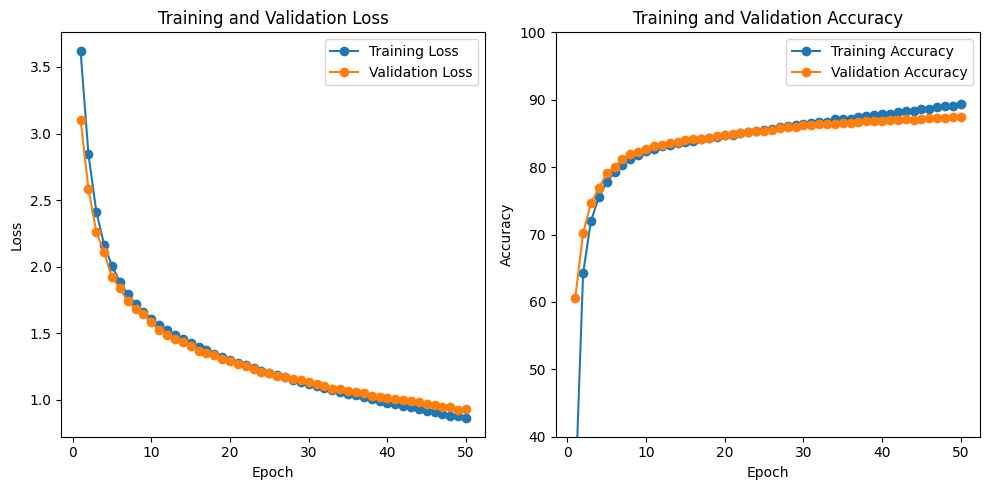

Test Accuracy: 87.3%, Avg loss: 0.916432 


In [17]:
fcn_resnet_101_model = Resnet101(num_classes=59)
fcn_resnet_101_model = fcn_resnet_101_model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcn_resnet_101_model.parameters(), lr=0.000001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
fcn_resnet_101_model_trainer = TransferLearningTrainer(fcn_resnet_101_model, optimizer, loss_fn, 50, EarlyStopper(patience=3, min_delta=0.01, max_loss_diff=0.15), device, scheduler)
fcn_resnet_101_model_trainer.train_and_val(train_loader, val_loader)
fcn_resnet_101_model_trainer.draw_results()
fcn_resnet_101_model_trainer.test(test_loader)

Finalmente, este se queda como el mejor modelo con un 87.3 % en test.

Guardamos todos los resultados que quedan:

In [24]:
trainers = {"MobileNetV3": mobilenetv3_trainer, "ResNet50":resnet50_trainer, 
            "Resnet101":fcn_resnet_101_model_trainer}
for k,v in trainers.items():
    #v.result.to_csv(r".\results\\" + k + ".csv" ,index=False)
    #torch.save(v.model.state_dict(), r".\results\\" + k + ".pth")
    pass

# Resultados

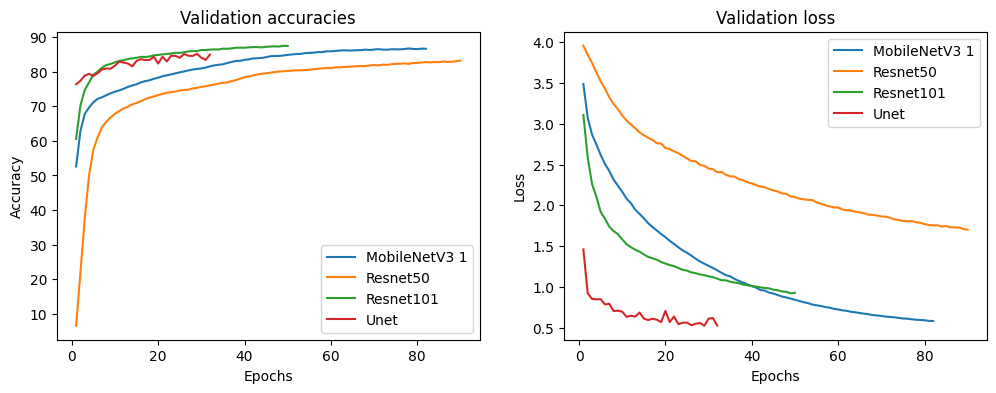

In [27]:
csv_files = ['MobileNetV3.csv', 'Resnet50.csv', 'Resnet101.csv', 'Unet.csv']
model_names = ['MobileNetV3 1', 'Resnet50', 'Resnet101', 'Unet']

val_loss_data = []
val_acc_data = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(r".\results\\" + csv_file)
    ax1.plot(df["Epoch"], df["val_acc"], label=model_names[i])
    ax2.plot(df["Epoch"], df["val_loss"], label=model_names[i])

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Validation accuracies')
ax1.legend()

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Validation loss')
ax2.legend()

plt.show()

La resnet50 es posible que necesite más épocas y la U-net un learning rate más bajo. Por otro lado es discutible la mejor entre MobileNetV3 con mejor pérdida, y Resnet101 con mejor accuracy. 

Aunque, la diferencia es mínima entre esas dos redes, la MobileNetV3 pesa 3 veces menos que la Resnet101, conviertiendola en lo que denominamos la red ideal para este caso.

Una matriz de confusión en este caso no es muy intuitiva, pues las matrices de confusión tratan de visualizar que clases predice con mejor acierto y con cuáles confunde las de peor acierto. Sin embargo, cuando tratamos con salidas como la siguiente por cada muestra:

real_classes = ['none', 'hair', 'skin', 'sunglasses', 'vest', 'blouse', 'skirt', 'stockings', 'shoes']
predicted_classes = ['none', 'hair', 'skin', 'blouse', 'blazer', 'suit', 'shorts', 'dress', 'jacket', 'coat', 'jeans', 'bag', 'skirt', 'shoes']

No podemos saber que confundió con una mochila de forma directa sin comprobaciones píxel por píxel.

Si podemos ver cuales suele acertar y cuales suele fallar, comenzamos calculando las labels predichas para todo el test:

In [15]:

model = MobileNetV3(59).to(device)
model.load_state_dict(torch.load("./results/MobileNetV3.pth"))
model.eval()
count = 0
max_test = 10
decoder = LabelDecoder(class_dict_path="./data/class_dict.csv", encoder_path='one_hot_encoder.joblib')

def model_output(model, x, y):
    out = model(x.unsqueeze(0))["out"].argmax(1).squeeze(0)
    return torch.zeros_like(y).to(device).scatter_(0, out.unsqueeze(0), 1.)

predict_list = []
real_list = []
for x, y in test_loader:
    for input, label in zip(x.unbind(0), y.unbind(0)):       
        predict, classes_predicted = decoder.decode_labels(model_output(model, input.to(device), label.to(device)).cpu())
        img, classes_real = decoder.decode_labels(label)
        predict_list.append(classes_predicted)
        real_list.append(classes_real)  

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Calculamos, para cada clase, cuántas predijo bien, cuántas predijo erróneamente y cuántas reales no llego a predecir:

In [16]:
dicc_good = {}
dicc_not_predicted = {}
dicc_bad_predicted = {}
def add_to_dic(dic, item):
    if item not in dic.keys():
        dic[item] = 1
    else:
        dic[item] += 1
               
for i in range(len(real_list)):
    predicted_copy = predict_list[i].copy()
    for j in range(len(real_list[i])):
        if real_list[i][j] in predict_list[i]:
            add_to_dic(dicc_good, real_list[i][j])
            predicted_copy.remove(real_list[i][j])
        else:
            add_to_dic(dicc_not_predicted, real_list[i][j])
    for class_not_predicted in predicted_copy:
        add_to_dic(dicc_bad_predicted, class_not_predicted)

Las rellenamos las faltantes y ordenamos:

In [17]:


for classs in encoded_df.class_name:
    for dict in [dicc_good, dicc_bad_predicted, dicc_not_predicted]:
        if classs not in dict.keys():
            dict[classs] = 0
        dict = OrderedDict(sorted(dict.items()))
        
dicc_good = OrderedDict(sorted(dicc_good.items()))
dicc_bad_predicted = OrderedDict(sorted(dicc_bad_predicted.items()))
dicc_not_predicted = OrderedDict(sorted(dicc_not_predicted.items()))

Mostramos los resultados de cada clase:

In [28]:
results[["Good predict",
"Bad predict",
"Not predicted"]].sum(axis=1)

0      40
1     110
2      39
3      45
4      63
5       1
6       3
7       0
8      16
9       4
10      2
11      0
12     85
13     68
14      0
15      3
16      3
17      2
18    152
19     17
20      5
21      1
22      0
23     24
24     46
25      4
26      3
27      4
28      6
29    152
30      0
31     83
32      3
33     46
34      2
35      1
36     10
37     20
38     42
39    150
40     12
41    152
42     42
43      1
44      8
45     19
46     33
47     43
48     44
49      4
50      0
51     30
52      2
53      0
54      9
55     10
56      1
57      8
58      0
dtype: int64

In [29]:
labels = encoded_df.class_name

all_values = list(dicc_good.values())
all_values.extend(list(dicc_bad_predicted.values()))
all_values.extend(list(dicc_not_predicted.values()))

max_value = max(all_values)
values1 = np.array(list(dicc_good.values()))
values2 = np.array(list(dicc_bad_predicted.values())) 
values3 = np.array(list(dicc_not_predicted.values())) 
results = pd.DataFrame({"Label":dicc_good.keys(), "Good predict":values1, "Bad predict":values2, "Not predicted":values3})
results[["Good predict", "Bad predict", "Not predicted"]] =\
    results[["Good predict","Bad predict","Not predicted"]].div(results[["Good predict","Bad predict","Not predicted"]].sum(axis=1), axis=0) # normalizamos cada fila
results.sort_values(by=['Good predict'], ascending=False)

,Label,Good predict,Bad predict,Not predicted
29,none,1.000000,0.000000,0.000000
41,skin,1.000000,0.000000,0.000000
18,hair,0.947368,0.052632,0.000000
39,shoes,0.786667,0.206667,0.006667
40,shorts,0.666667,0.083333,0.250000
13,dress,0.632353,0.323529,0.044118
31,pants,0.542169,0.457831,0.000000
45,stockings,0.526316,0.105263,0.368421
1,bag,0.490909,0.363636,0.145455
42,skirt,0.476190,0.428571,0.095238


De la ropa, los pantalones cortos, zapatos, pantalones y vestidos. Son lo que mejor predice.

In [30]:
results.sort_values(by=['Bad predict'], ascending=False)

,Label,Good predict,Bad predict,Not predicted
3,blazer,0.244444,0.644444,0.111111
12,coat,0.388235,0.611765,0.000000
46,suit,0.333333,0.606061,0.060606
48,sweater,0.181818,0.590909,0.227273
23,jacket,0.416667,0.541667,0.041667
9,cape,0.000000,0.500000,0.500000
24,jeans,0.456522,0.500000,0.043478
38,shirt,0.214286,0.500000,0.285714
51,t-shirt,0.400000,0.466667,0.133333
31,pants,0.542169,0.457831,0.000000


Se equivoca prediciendo demás los abrigos, blusas y en general, ropa de abrigo.

In [31]:
results.sort_values(by=['Not predicted'], ascending=False)

,Label,Good predict,Bad predict,Not predicted
0,accessories,0.000000,0.000000,1.000000
35,romper,0.000000,0.000000,1.000000
25,jumper,0.000000,0.000000,1.000000
26,leggings,0.000000,0.000000,1.000000
27,loafers,0.000000,0.000000,1.000000
28,necklace,0.000000,0.000000,1.000000
32,pumps,0.000000,0.000000,1.000000
34,ring,0.000000,0.000000,1.000000
36,sandals,0.000000,0.000000,1.000000
20,heels,0.000000,0.000000,1.000000


Le cuesta mucho predecir detalles pequeños como accesorios y en general ropa pequeña difícil de ver.

Real classes: ['none', 'hair', 'skin', 'blouse', 'belt', 'pants', 'accessories', 'bracelet', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'blouse', 'pants', 'shoes']


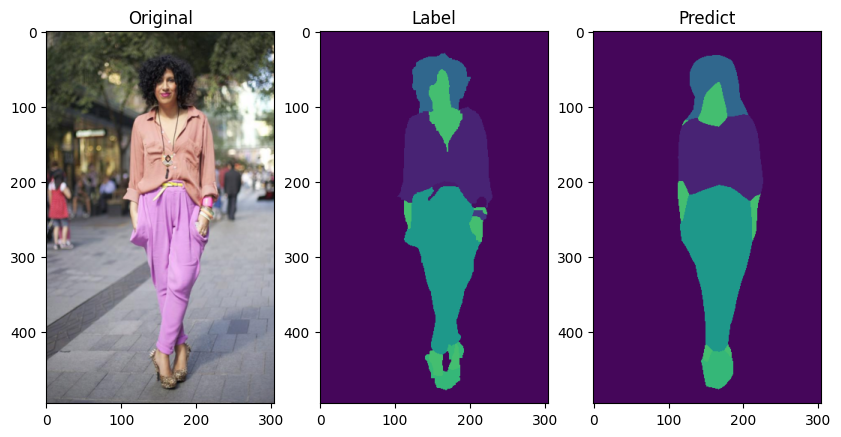

Real classes: ['none', 'hair', 'skin', 'blouse', 'bag', 'skirt', 'shoes']
Predicted classes: ['none', 'hair', 'blouse', 'skin', 'skirt', 'bag', 'shoes']


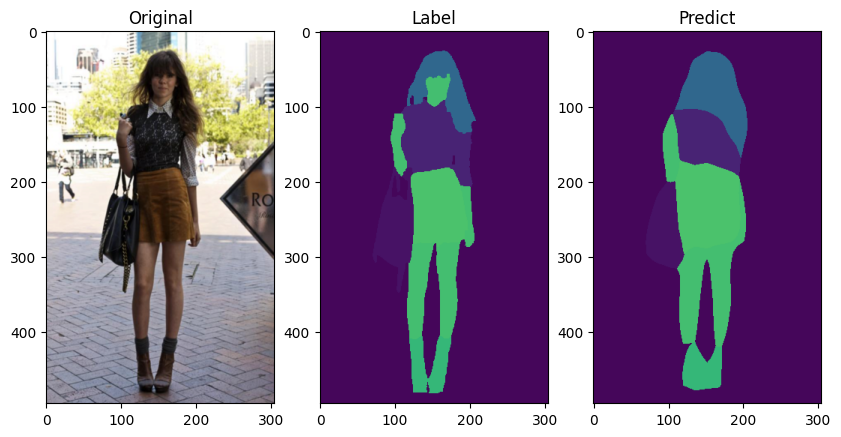

Real classes: ['none', 'hair', 'skin', 'sunglasses', 'scarf', 'coat', 'skirt', 'bag', 'jeans', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'suit', 'skirt', 'pants', 'bag', 'shoes']


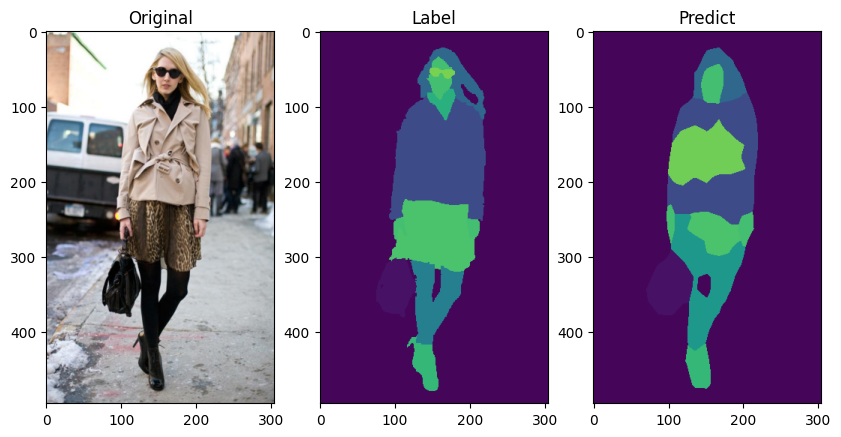

Real classes: ['none', 'hat', 'skin', 't-shirt', 'shorts', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 't-shirt', 'shirt', 'shorts', 'jeans', 'shoes']


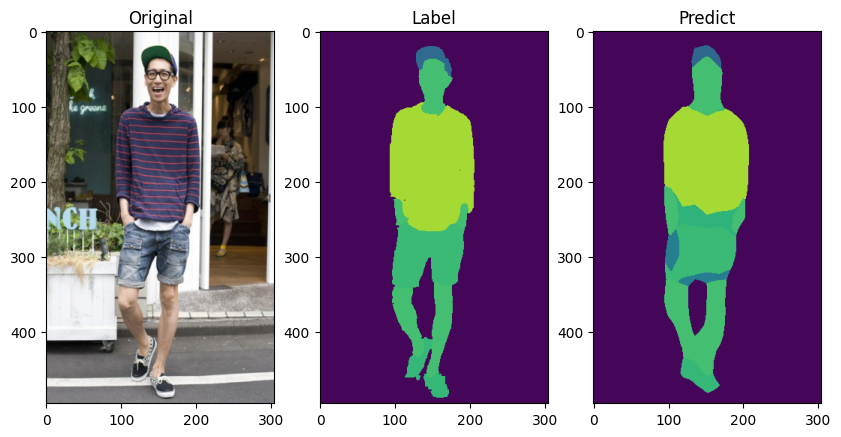

Real classes: ['none', 'hat', 'hair', 'skin', 'sweatshirt', 'bag', 'bracelet', 'dress', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'blazer', 'bag', 'blouse', 'sweater', 'dress', 'shoes']


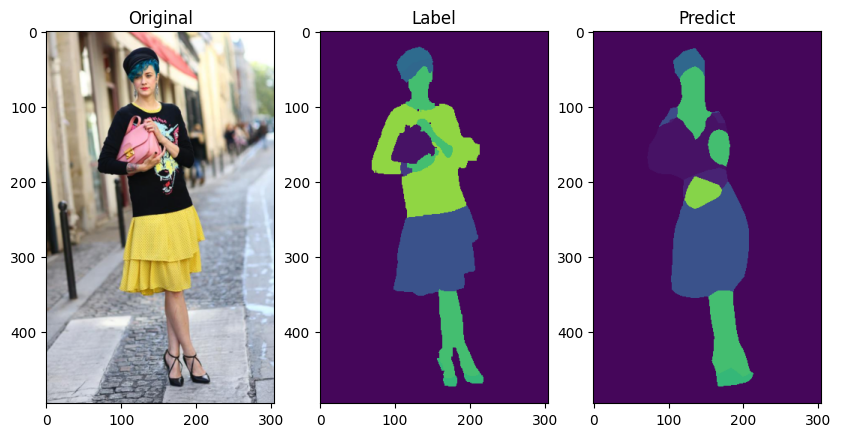

Real classes: ['none', 'hair', 'skin', 'coat', 'top', 'bag', 'pants', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'coat', 'sweater', 'pants', 'shoes']


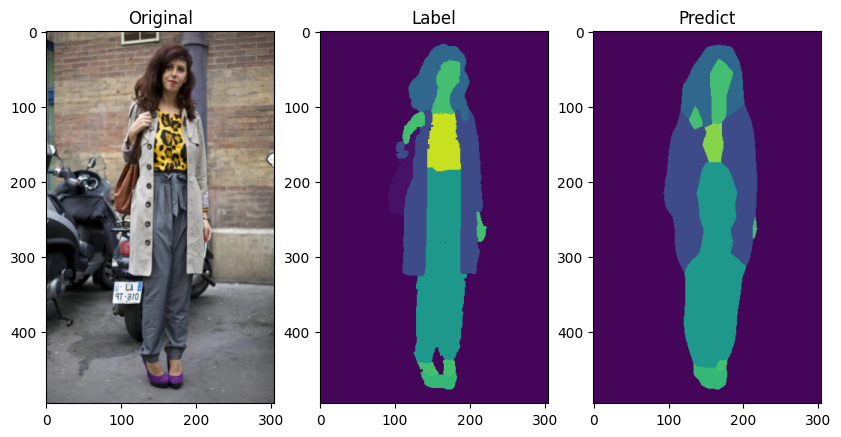

Real classes: ['none', 'hair', 'skin', 'vest', 'scarf', 'skirt', 'purse', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'blouse', 't-shirt', 'vest', 'pants', 'dress', 'skirt', 'bag', 'shoes']


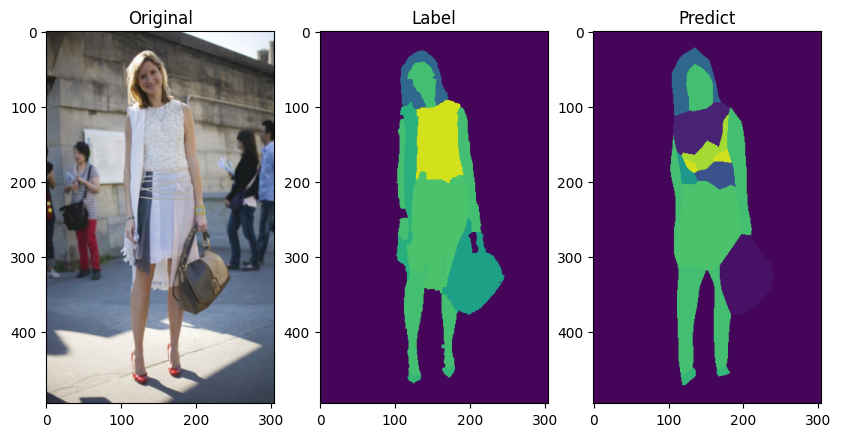

Real classes: ['none', 'hat', 'hair', 'skin', 'shirt', 'blazer', 'shorts', 'purse', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'dress', 'coat', 'blouse', 'blazer', 'jacket', 'skirt', 'sweater', 'shirt', 'shorts', 'bag', 'purse', 'shoes']


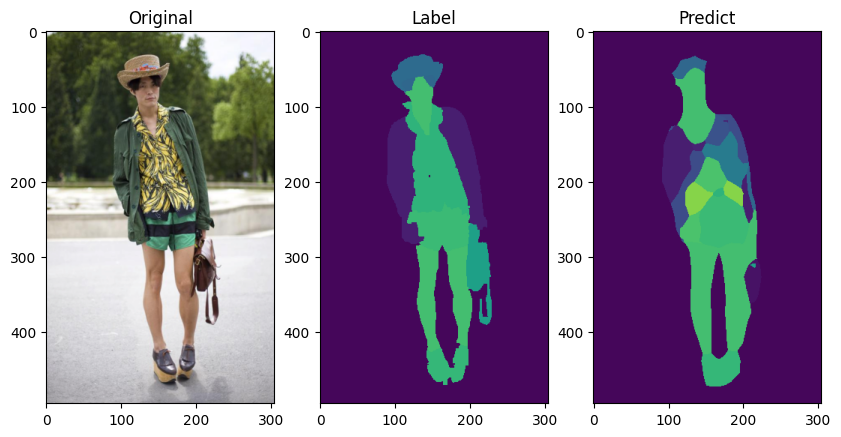

Real classes: ['none', 'hair', 'skin', 'sunglasses', 'shirt', 'suit', 'purse', 'accessories', 'pants', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'suit', 'bag', 'pants', 'shoes']


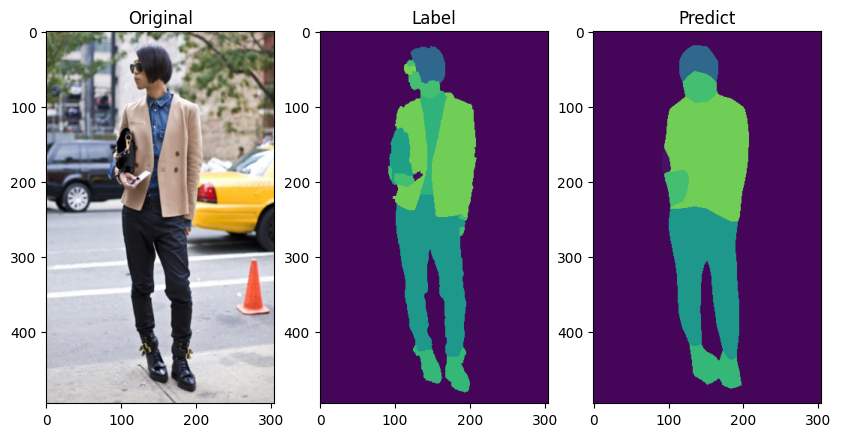

Real classes: ['none', 'blazer', 'hair', 'skin', 'sunglasses', 'sweater', 'jeans', 'accessories', 'shoes']
Predicted classes: ['none', 'hair', 'skin', 'blazer', 'jeans', 'shoes']


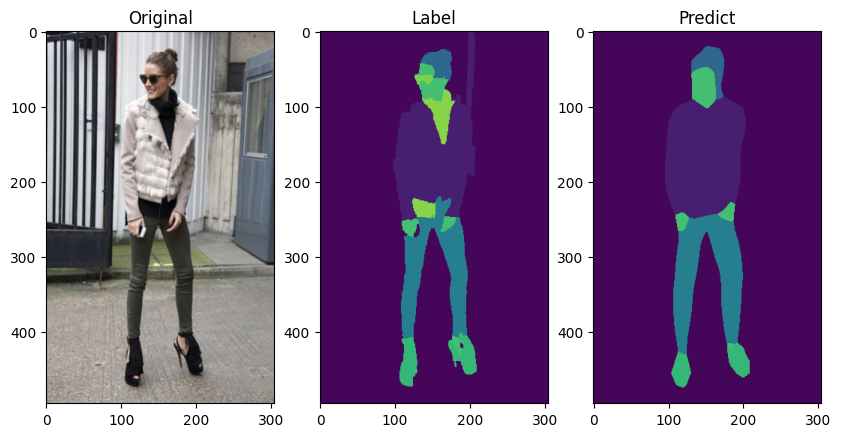

In [32]:
undo_transforms = transforms.Compose([
    transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    ),
    transforms.Lambda(lambda x: x * 255)    
])

for x, y in test_loader:
    for input, label in zip(x.unbind(0), y.unbind(0)):       
        predict, classes_predicted = decoder.decode_labels(model_output(model, input.to(device), label.to(device)).cpu())
        img_label, classes_real = decoder.decode_labels(label)
    
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original")

        input = undo_transforms(input)

        plt.imshow(np.transpose(input.int(), (1, 2, 0)))
        plt.subplot(1, 3, 2)

        plt.imshow(img_label)
        plt.title("Label")
        plt.subplot(1, 3, 3)

        plt.imshow(predict)
        plt.title("Predict")
        print("Real classes:", classes_real)
        print("Predicted classes:", classes_predicted)
        plt.show()
        break

El modelo no se ajusta bien a cambios de iluminación, probablemente se deba a una falta de data augmentation basado en cambiar niveles de iluminisidad.

#### Test final

Predicted classes: ['none', 'hair', 'skin', 'coat', 'blouse', 'sweater', 'pants', 'shoes']


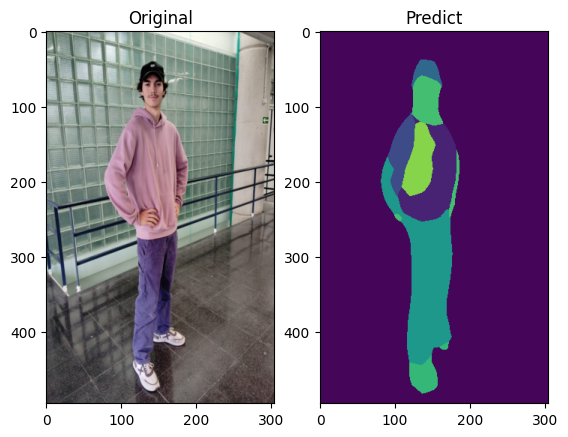

In [33]:

input = read_image("./data/dani2.jpg")
transformation = transforms.Compose([
    transforms.Resize((496, 304), interpolation=InterpolationMode.BILINEAR, antialias=True), 
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input = transformation(input)

predict, classes_predicted = decoder.decode_labels(model_output(model, input.to(device), label.to(device)).cpu())

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
input = undo_transforms(input)
plt.imshow(np.transpose(input.int(), (1, 2, 0)))
plt.subplot(1, 3, 2)
plt.imshow(predict)
plt.title("Predict")

print("Predicted classes:", classes_predicted)
plt.show()
